# Quickstart

#### If you only want to run current injection simulations using our L5tt model, please do the following:
1. download and install Anaconda 2.7 https://www.continuum.io/Downloads
2. install neuron such that you can import it as python module
3. install sumatra: `pip install sumatra`
4. clone the single_cell_parser git respository: `git clone https://github.com/abast/single_cell_parser.git`
5. Add the resulting folder single_cell_parser to the PYTHONPATH variable: `export PYTHONPATH=$PYTHONPATH:/my/freshly/cloned/repository`
6. make sure you can import that module in python: `import single_cell_parser as scp`
7. open the file 86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param and adapt the following paths:
       "NMODL_mechanisms" --> "channels": has to point to the absolute path of the mechanism/channels subfolder in the single_cell_parser_module
       "neuron" --> "filename": has to point to the neuron morphology
       
If you want to try out the simulator immediately, jump to "How to simulate current injections"

##### What are these packages doing?
 - sumatra: we use it to read and write to parameterfiles (which might be a bit of an overkill)
 - single_cell_parser: module written by Robert Egger wrapping around neuron. It provides a high level interface specifically build to simulate full compartmental models and synaptic input.

    
#### If you also want to run simulations with synaptic input, please install in addition:
1. install pandas from git master: `pip install -U git+https://github.com/pandas-dev/pandas.git` (it has to contain this commit: https://github.com/pandas-dev/pandas/pull/15493)
2. dask 0.14: `conda install dask==0.14`
3. distributed 1.15.2: `conda install distributed=1.15.2`
4. SingleCellInputMapper: `git clone https://github.com/abast/SingleCellInputMapper.git`
5. Add the resulting folder to the PYTHONPATH variable: `export PYTHONPATH=$PYTHONPATH:/my/freshly/cloned/repository`
6. simrun: 

#### If you want to have an easy python interface to the simulation results, please install in addition:
1. install model_data_base
2. install seaborn from git master pip install -U git+https://github.com/pandas/pandas.githttps://github.com/mwaskom/seaborn.git (it has to contain this commit: https://github.com/mwaskom/seaborn/issues/966)
    

#### If you want to run the test suite, please install in addition:
1. install mock (conda install mock)

# How to simulate current injections
This is an example of a coincident current injection in the apical dendrite and the soma, which triggers a burst.

In [8]:
'''
Created on Jan 28, 2013

passive properties L2 neuron model

@author: robert
'''

import sys
import time
import os, os.path
import neuron
import single_cell_parser as scp
import numpy as np
import matplotlib.pyplot as plt
h = neuron.h

def test_BAC_firing(fname, iAmpSoma = 1.9, iAmpApical = 0.5):
    neuronParameters = scp.build_parameters(fname)
    scp.load_NMODL_parameters(neuronParameters)
    cellParam = neuronParameters.neuron
    
    cell = scp.create_cell(cellParam, scaleFunc=scale_apical) #we need to scale apical dendrite
    
    totalArea = 0.0
    somaArea = 0.0
    apicalArea = 0.0
    basalArea = 0.0
    axonArea = 0.0
    for sec in cell.sections:
        totalArea += sec.area
        if sec.label == 'Soma':
            somaArea += sec.area
        if sec.label == 'ApicalDendrite':
            for seg in sec:
                apicalArea += h.area(seg.x, sec=sec)
#            apicalArea += sec.area
        if sec.label == 'Dendrite':
            basalArea += sec.area
        if sec.label == 'AIS' or sec.label == 'Myelin':
            axonArea += sec.area
    
    print 'total area = %.2f micron^2' % totalArea
    print 'soma area = %.2f micron^2' % somaArea
    print 'apical area = %.2f micron^2' % apicalArea
    print 'basal area = %.2f micron^2' % basalArea
    print 'axon area = %.2f micron^2' % axonArea
    
    tStop = 600.0
    neuronParameters.sim.tStop = tStop
#    neuronParameters.sim.dt = 0.005
    tIStart = 295.0
    duration = 5.0
    apicalDt = 5.0

    apicalTauRise = 1.0
    apicalTauDecay = 5.0
    apicalBifurcationDistance = 800.0 # cell ID 86
    apicalInjectionDistance = 620.0 # cell ID 86

    apicalBifurcationSec = get_apical_section_at_distance(cell, apicalBifurcationDistance)
    
    visualize = False
#    t1, vmSoma1, vmApical1 = soma_injection(cell, iAmpSoma, tIStart, duration, apicalBifurcationSec, apicalInjectionDistance, neuronParameters.sim, visualize)
#    t2, vmSoma2, vmApical2 = apical_injection(cell, apicalBifurcationSec, apicalInjectionDistance, iAmpApical, tIStart, apicalTauRise, apicalTauDecay, neuronParameters.sim, visualize)
    t3, vmSoma3, vmApical3 = soma_apical_injection(cell, iAmpSoma, tIStart, duration, apicalBifurcationSec, apicalInjectionDistance, iAmpApical, apicalDt, apicalTauRise, apicalTauDecay, neuronParameters.sim, visualize)

    
    showPlots = True
    if showPlots:

        plt.title('apical current injection amp=%.2f nA' % (iAmpApical))
        plt.legend()
        plt.figure(3)
        plt.plot(t3, vmSoma3, 'k', label='soma')
        plt.plot(t3, vmApical3, 'r', label='apical')
        plt.xlabel('time [ms]')
        plt.ylabel('Vm [mV]')
        plt.title('soma + apical current injection amp=%.2f/%.2f nA' % (iAmpSoma, iAmpApical))
        plt.legend()
        plt.show()
    
    cell.t = t3
    return cell

def soma_apical_injection(cell, somaAmplitude, somaDelay, somaDuration, apicalBifurcationSec, apicalInjectionDistance, apicalAmplitude,\
                          apicalDelayDt, apicalTauRise, apicalTauDecay, simParam, saveVisualization=False):
    print 'selected apical section:'
    print apicalBifurcationSec.name()
    somaDist = cell.distance_to_soma(apicalBifurcationSec, 0.0)
    apicalx = (apicalInjectionDistance - somaDist)/apicalBifurcationSec.L
    print 'distance to soma: %.2f micron' % somaDist
    print 'apicalInjectionDistance: %.2f micron' % apicalInjectionDistance
    print 'apicalx: %.2f' % apicalx
    
    iclamp = h.IClamp(0.5, sec=cell.soma)
    iclamp.delay = somaDelay
    iclamp.dur = somaDuration
    iclamp.amp = somaAmplitude
    
    iclamp2 = h.epsp(apicalx, sec=apicalBifurcationSec)
    iclamp2.onset = somaDelay + apicalDelayDt
    iclamp2.imax = apicalAmplitude
    iclamp2.tau0 = apicalTauRise
    iclamp2.tau1 = apicalTauDecay
        
    print 'soma current injection: %.2f nA' % somaAmplitude
    print 'apical current injection: %.2f nA' % apicalAmplitude
    tVec = h.Vector()
    tVec.record(h._ref_t)
    startTime = time.time()
    scp.init_neuron_run(simParam, vardt=False)
    stopTime = time.time()
    dt = stopTime - startTime
    print 'NEURON runtime: %.2f s' % dt
    
    vmSoma = np.array(cell.soma.recVList[0])
    minSeg = -1
    mindx = 1.0
    for i in range(len(apicalBifurcationSec.segx)):
        x = apicalBifurcationSec.segx[i]
        dx = np.abs(x-apicalx)
        if dx < mindx:
            mindx = dx
            minSeg = i
    vmApical = np.array(apicalBifurcationSec.recVList[minSeg])
    t = np.array(tVec)
    
    if saveVisualization:
        visFName = 'visualization/soma_apical_injection_86/'
        visFName += 'soma_apical_current_injection_soma_amp_%.1fnA_dur_%.0fms_apical_amp_%.1fnA_dt_%.0fms' % (somaAmplitude, somaDuration, apicalAmplitude, apicalDelayDt)
        scp.write_cell_simulation(visFName, cell, ['Vm'], t, allPoints=True)
    #cell.re_init_cell()
    
    return t, vmSoma, vmApical

def get_apical_section_at_distance(cell, distance):
    '''determine interior apical dendrite section (i.e. no ending section)
    closest to given distance'''
    closestSec = None
    minDist = 1e9
    for branchSectionList in cell.branches['ApicalDendrite']:
        for sec in branchSectionList:
            secRef = h.SectionRef(sec=sec)
            if secRef.nchild():
                dist = cell.distance_to_soma(sec, 1.0)
                dist = abs(dist - distance)
                if dist < minDist:
                    minDist = dist
                    closestSec = sec
    return closestSec

def scale_apical(cell):
    '''
    scale apical diameters depending on
    distance to soma; therefore only possible
    after creating complete cell
    '''
    dendScale = 2.5
    scaleCount = 0
    for sec in cell.sections:
        if sec.label == 'ApicalDendrite':
            dist = cell.distance_to_soma(sec, 1.0)
            if dist > 1000.0:
                continue
            if scaleCount > 32:
                break
            scaleCount += 1
            for i in range(sec.nrOfPts):
                oldDiam = sec.diamList[i]
                newDiam = dendScale*oldDiam
                h.pt3dchange(i, newDiam, sec=sec)
    
    print 'Scaled %d apical sections...' % scaleCount

def write_sim_results(fname, t, v):
    with open(fname, 'w') as outputFile:
        header = '# simulation results\n'
        header += '# t\tvsoma'
        header += '\n\n'
        outputFile.write(header)
        for i in range(len(t)):
            line = str(t[i])
            line += '\t'
            line += str(v[i])
            line += '\n'
            outputFile.write(line)


Mechanisms already loaded from path: /nas1/Data_arco/project_src/single_cell_parser/mechanisms/channels/.  Aborting.
-------------------------------
Starting setup of cell model...
Loading cell morphology...
Reading hoc file /nas1/Data_arco/project_src/single_cell_parser/example_files/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc
Creating AIS:
    axon hillock diameter: 3.00
    initial segment diameter: 1.75
    myelin diameter: 1.00
Scaled 33 apical sections...
Setting up biophysical model...
    Adding membrane properties to Myelin
    Adding membrane properties to Soma
    Adding membrane properties to AIS
    Adding membrane properties to Dendrite
    Adding membrane properties to ApicalDendrite
    Setting up spatial discretization...
    Total number of compartments in model: 1109
    Total length of model cell: 15290.39
    Average compartment length: 13.79
    Maximum compartment (Dendrite) length: 31.54
    Adding membrane range mechanisms to Myeli

/nas1/Data_arco/prgr/Anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


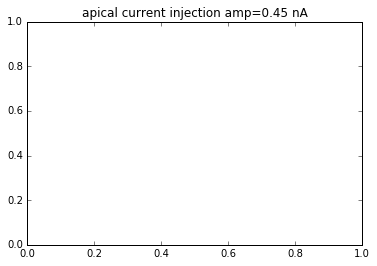

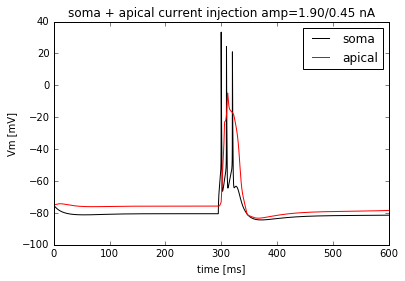

In [15]:
path_to_cell_param_file = '/nas1/Data_arco/project_src/single_cell_parser/example_files/86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param' #adapt this path
cell = test_BAC_firing(path_to_cell_param_file, iAmpApical = 0.45)

# How to simulate synaptic input